# LMS自适应算法 - 代码实现与可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. LMS算法核心实现

In [2]:
def lms_filter(x, d, M, mu):
    """LMS自适应滤波器\n    参数: x-输入信号, d-期望信号, M-滤波器阶数, mu-步长\n    返回: y-输出, e-误差, w_history-权值历史"""
    N = len(x)
    w = np.zeros(M)
    y, e = np.zeros(N), np.zeros(N)
    w_history = [w.copy()]
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]  # 输入向量
        y[n] = np.dot(w, x_vec)  # 滤波器输出
        e[n] = d[n] - y[n]       # 误差
        w = w + mu * e[n] * x_vec  # LMS更新
        w_history.append(w.copy())
    return y, e, np.array(w_history)

In [3]:
def nlms_filter(x, d, M, mu, eps=1e-6):
    """归一化LMS (NLMS) 算法"""
    N = len(x)
    w = np.zeros(M)
    y, e = np.zeros(N), np.zeros(N)
    w_history = [w.copy()]
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]
        y[n] = np.dot(w, x_vec)
        e[n] = d[n] - y[n]
        norm_factor = np.dot(x_vec, x_vec) + eps
        w = w + (mu / norm_factor) * e[n] * x_vec
        w_history.append(w.copy())
    return y, e, np.array(w_history)

## 2. 示例1: 系统辨识

In [4]:
# 未知系统 (要辨识的目标)
w_true = np.array([0.5, -0.3, 0.2, 0.1])
M = len(w_true)
N = 1000

# 生成输入信号 (白噪声)
x = np.random.randn(N)

# 未知系统输出 + 观测噪声
d = np.convolve(x, w_true, mode='full')[:N] + 0.1 * np.random.randn(N)

# LMS辨识
mu = 0.05
y, e, w_history = lms_filter(x, d, M, mu)

print(f'真实系数: {w_true}')
print(f'LMS估计: {w_history[-1]}')
print(f'估计误差: {np.linalg.norm(w_true - w_history[-1]):.6f}')

真实系数: [ 0.5 -0.3  0.2  0.1]
LMS估计: [-0.306346    0.13188029  0.15071195 -0.0604037 ]
估计误差: 0.929986


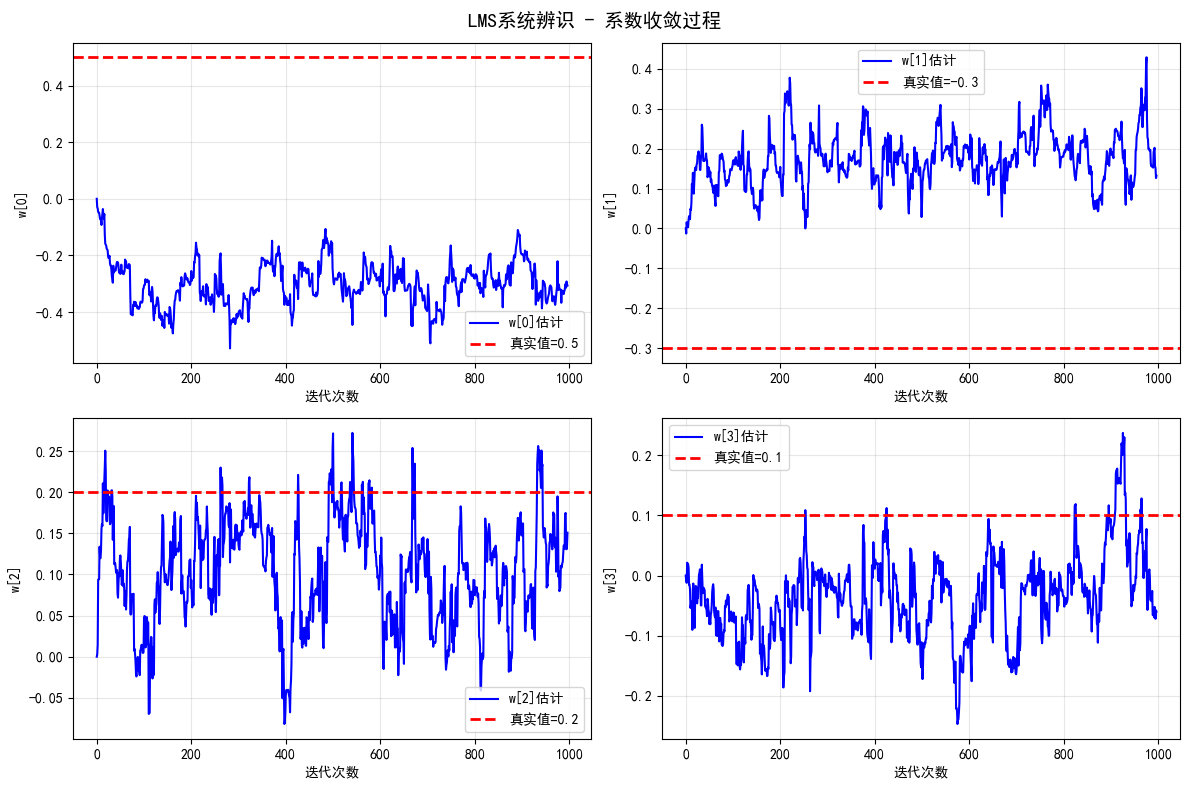

In [5]:
# 可视化系数收敛
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(M):
    ax = axes[i//2, i%2]
    ax.plot(w_history[:, i], 'b-', linewidth=1.5, label=f'w[{i}]估计')
    ax.axhline(y=w_true[i], color='r', linestyle='--', linewidth=2, label=f'真实值={w_true[i]}')
    ax.set_xlabel('迭代次数')
    ax.set_ylabel(f'w[{i}]')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.suptitle('LMS系统辨识 - 系数收敛过程', fontsize=14)
plt.tight_layout()
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

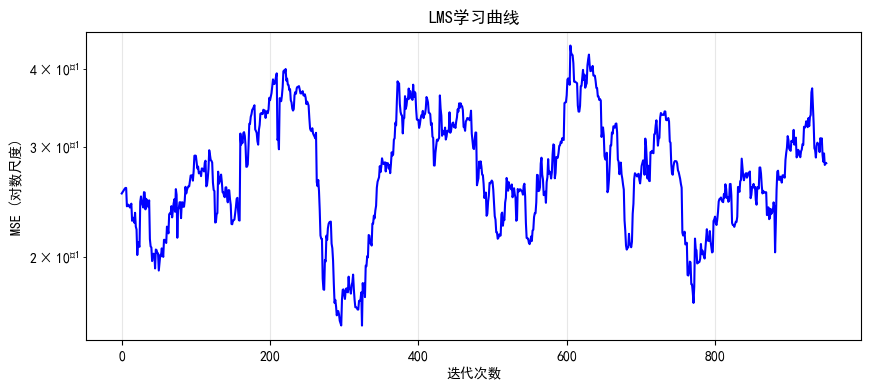

In [6]:
# 学习曲线 (MSE vs 迭代)
window = 50
mse = np.convolve(e**2, np.ones(window)/window, mode='valid')
plt.figure(figsize=(10, 4))
plt.semilogy(mse, 'b-', linewidth=1.5)
plt.xlabel('迭代次数')
plt.ylabel('MSE (对数尺度)')
plt.title('LMS学习曲线')
plt.grid(True, alpha=0.3)
plt.show()

## 3. 示例2: 噪声消除

In [7]:
# 生成信号
N = 2000
t = np.arange(N) / 1000

# 原始信号 (正弦波)
signal = np.sin(2 * np.pi * 5 * t)

# 噪声源
noise_source = np.random.randn(N)

# 噪声经过未知路径到达传感器
noise_path = np.array([1.0, 0.5, -0.3])
noise_at_sensor = np.convolve(noise_source, noise_path, mode='full')[:N]

# 传感器接收: 信号 + 噪声
d = signal + noise_at_sensor  # 主传感器
x = noise_source  # 参考传感器 (只有噪声)

# 自适应噪声消除
M = 8
mu = 0.1
y, e, _ = lms_filter(x, d, M, mu)  # e是去噪后的信号

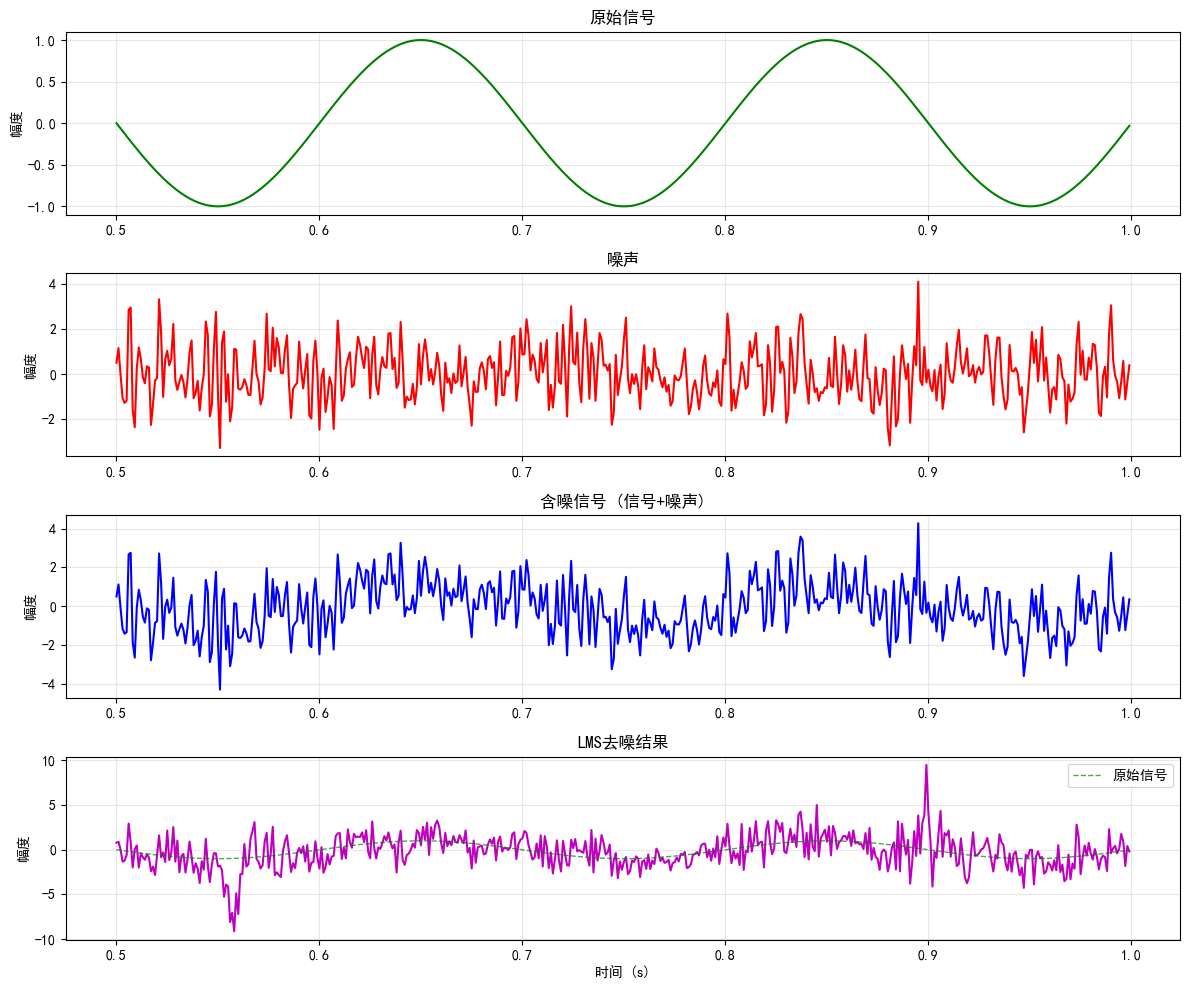

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
start, end = 500, 1000

axes[0].plot(t[start:end], signal[start:end], 'g-', linewidth=1.5)
axes[0].set_title('原始信号')
axes[0].set_ylabel('幅度')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[start:end], noise_at_sensor[start:end], 'r-', linewidth=1.5)
axes[1].set_title('噪声')
axes[1].set_ylabel('幅度')
axes[1].grid(True, alpha=0.3)

axes[2].plot(t[start:end], d[start:end], 'b-', linewidth=1.5)
axes[2].set_title('含噪信号 (信号+噪声)')
axes[2].set_ylabel('幅度')
axes[2].grid(True, alpha=0.3)

axes[3].plot(t[start:end], e[start:end], 'm-', linewidth=1.5)
axes[3].plot(t[start:end], signal[start:end], 'g--', linewidth=1, alpha=0.7, label='原始信号')
axes[3].set_title('LMS去噪结果')
axes[3].set_xlabel('时间 (s)')
axes[3].set_ylabel('幅度')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 步长对收敛的影响

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

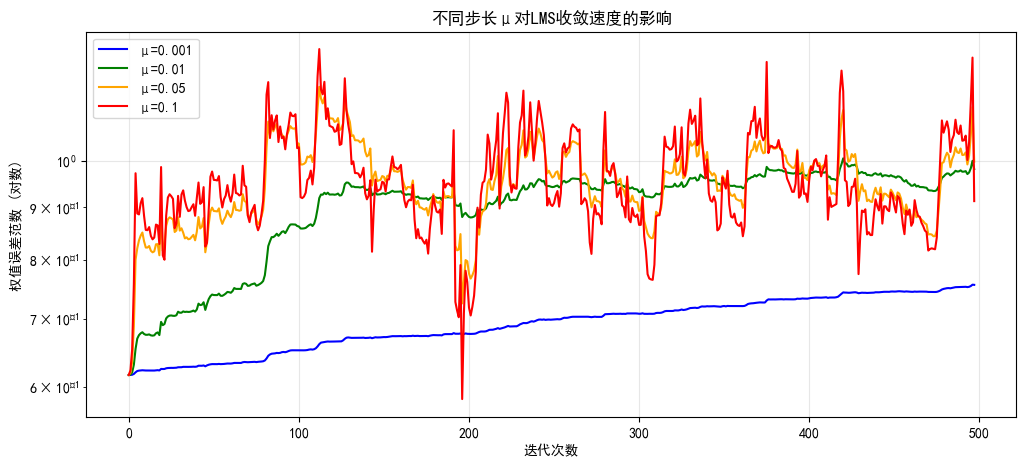

In [9]:
# 不同步长比较
mu_values = [0.001, 0.01, 0.05, 0.1]
colors = ['blue', 'green', 'orange', 'red']

w_true = np.array([0.5, -0.3, 0.2])
M = len(w_true)
N = 500
x = np.random.randn(N)
d = np.convolve(x, w_true, mode='full')[:N] + 0.05 * np.random.randn(N)

plt.figure(figsize=(12, 5))
for mu, color in zip(mu_values, colors):
    _, e, w_hist = lms_filter(x, d, M, mu)
    # 计算权值误差范数
    w_error = [np.linalg.norm(w - w_true) for w in w_hist]
    plt.semilogy(w_error, color=color, linewidth=1.5, label=f'μ={mu}')

plt.xlabel('迭代次数')
plt.ylabel('权值误差范数 (对数)')
plt.title('不同步长μ对LMS收敛速度的影响')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. LMS vs NLMS比较

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


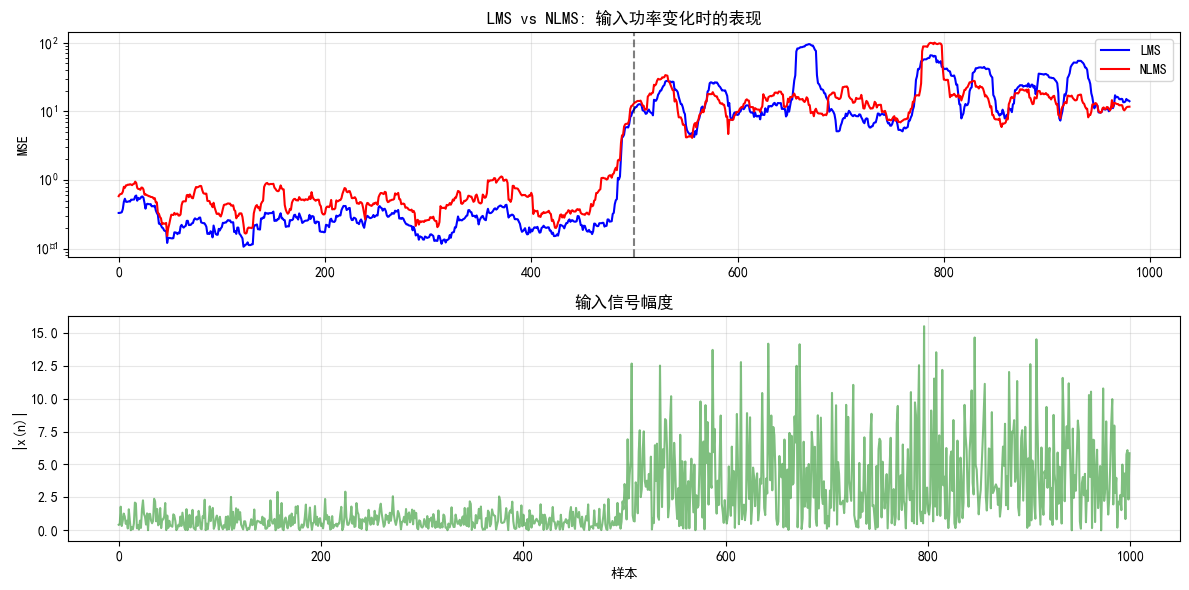

NLMS在输入功率变化时表现更稳定


In [10]:
# 非平稳输入信号
N = 1000
x = np.random.randn(N)
x[500:] *= 5  # 后半段功率增大5倍

w_true = np.array([0.5, -0.3, 0.2])
M = len(w_true)
d = np.convolve(x, w_true, mode='full')[:N] + 0.1 * np.random.randn(N)

# LMS和NLMS
_, e_lms, w_lms = lms_filter(x, d, M, mu=0.01)
_, e_nlms, w_nlms = nlms_filter(x, d, M, mu=0.5)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
window = 20

mse_lms = np.convolve(e_lms**2, np.ones(window)/window, mode='valid')
mse_nlms = np.convolve(e_nlms**2, np.ones(window)/window, mode='valid')

axes[0].semilogy(mse_lms, 'b-', label='LMS', linewidth=1.5)
axes[0].semilogy(mse_nlms, 'r-', label='NLMS', linewidth=1.5)
axes[0].axvline(x=500, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylabel('MSE')
axes[0].set_title('LMS vs NLMS: 输入功率变化时的表现')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(np.abs(x), 'g-', alpha=0.5)
axes[1].set_xlabel('样本')
axes[1].set_ylabel('|x(n)|')
axes[1].set_title('输入信号幅度')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print('NLMS在输入功率变化时表现更稳定')

## 6. 总结

- LMS算法简单高效，每次迭代O(M)复杂度
- 步长μ控制收敛速度和稳态误差的权衡
- NLMS对输入功率变化更鲁棒
- 适用于系统辨识、噪声消除、回声消除等场景